# Preprocessing and labeling

## Import and format data

In [1]:
import pandas as pd
import json

# Import json file
with open('dataset.json') as file:
    data = json.load(file)

# Convert json to pandas dataframe
df = pd.json_normalize(data)

# Split cuisines for double entries
df['cuisines_1'] = pd.json_normalize(pd.json_normalize(df['cuisines'])[0])['label']
df['cuisines_2'] = pd.json_normalize(pd.json_normalize(df['cuisines'])[1])['label']

# Select only relevant columns
df = df[['objectID', 'price_category.slug', 'cuisines_1', 'cuisines_2', 'more_details.full_images']].copy()

# Drop rows with missing values in price_category
df.dropna(subset=['price_category.slug'], inplace=True)

# Row for each image_id
df = df.explode('more_details.full_images')
df.reset_index(drop=True, inplace=True)
df['image_id'] = pd.json_normalize(df['more_details.full_images'])['image_id']
df.dropna(subset=['image_id'], inplace=True)
df.reset_index(drop=True, inplace=True)
df = df[['objectID', 'image_id', 'price_category.slug', 'cuisines_1', 'cuisines_2']].copy()
df.rename(columns={'price_category.slug': 'price_category'}, inplace=True)
df['image_id'] = df['image_id'].astype(str)
df['image_id'] = df['image_id'].apply(lambda x: x + '.jpg')

# Load image_labels.csv
image_labels = pd.read_csv('image_labels.csv', header=None)
image_labels.columns = ['image_id', 'labels']

# Merge image_labels with df
df = pd.merge(df, image_labels, on='image_id', how='left')

# Select only food images
df = df[df['labels'] == 'food']

## Clean data
First check all images and remove corrupted files.

In [2]:
import os
from PIL import Image
import numpy as np

# Count number of corrupted images
corrupted_images = []
for image_id in df['image_id']:    
    try:
        img = Image.open(os.path.join('images/' + str(image_id)))
        img.verify()
    except:
        corrupted_images.append(image_id)
print(corrupted_images) # 1 corrupted image: '4215425.jpg'

[]


In [3]:
# Save time by skipping the above step
corrupted_images = ['4215425.jpg']

# Drop corrupted images
df = df[df.image_id.isin(corrupted_images) == False].copy()

## Balance classes

In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(df[['image_id', 'price_category']], df['price_category'])

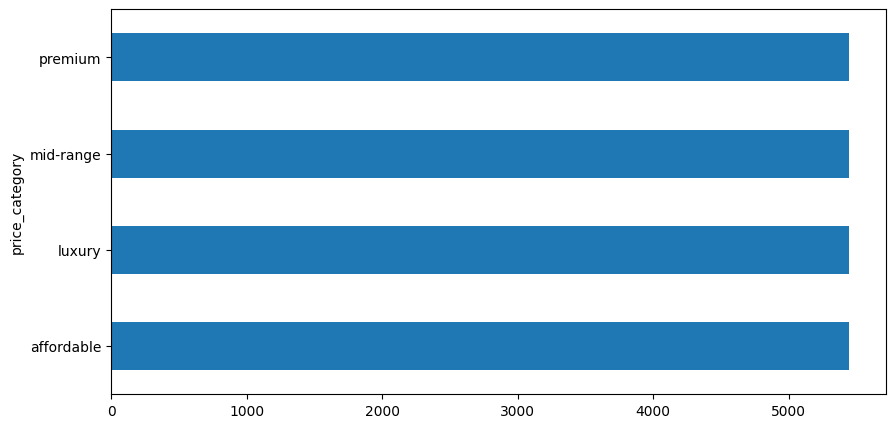

In [5]:
import matplotlib.pyplot as plt

# Plot distribution of cuisines
plt.figure(figsize=(10, 5))
pd.Series(y_resampled).value_counts().sort_values(ascending=True).plot(kind='barh')
plt.show()

# Create balanced dataframe
df_balanced = pd.DataFrame(X_resampled, columns=['image_id', 'price_category'])

# Save balanced dataframe
df_balanced.to_csv('labels_balanced.csv', index=False)

Export to csv

In [6]:
# Create csv
df.to_csv('labels.csv', index=False)